In [2]:
from os import path 

from keras.layers import Input
from keras.models import Model

import numpy as np

import blusky.datasets as datasets
from blusky.transforms.apply_father_wavelet_2d import ApplyFatherWavlet2D
from blusky.transforms.cascade_2d import Cascade2D
from blusky.transforms.cascade_tree import CascadeTree
from blusky.transforms.default_decimation import DefaultDecimation
from blusky.utils.pad_2d import Pad2D, pad_to_log2
from blusky.wavelets.wavelet_factories_2d import vanilla_gabor_2d, vanilla_morlet_2d

Using TensorFlow backend.


In [3]:
np.log2(128)

7.0

In [4]:
from PIL import Image
import matplotlib.pylab as plt
from cv2 import resize

img = np.array(Image.open("texture-bruna.png").convert('LA'))[...,0]
img = resize(img, (128,128))
img = np.expand_dims(img, axis=-1)

plt.figure()
plt.imshow(img[...,0])
plt.show()

<Figure size 640x480 with 1 Axes>

In [7]:
np.linspace(0,160,9)

array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.])

In [8]:
# Don't make this too huge for brevity.
J = 5
# 0 = no overlap etc.
overlap_log_2 = 0
# apply to all available orders
order = 2
# Should be one or more to avoid aliasing, if you want overlapping tiles, 
# this can increase too.
oversampling = 1 

angles=[  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160.]

# details of the input data
img_size = img.shape
sample_rate = 0.004*3

# vanilla filter bank
wavelets = [vanilla_morlet_2d(sample_rate, j=i) for i in range(0,J)]
father_wavelet = vanilla_gabor_2d(sample_rate, j=J)
print (father_wavelet.kernel(0.).shape)
# method of decimation
deci = DefaultDecimation(oversampling=oversampling)

# input
inp = Input(shape=img.shape)

# valid padding
cascade2d = Cascade2D("none", 
                    0, 
                    decimation=deci,
                    angles=angles)

# Pad the input
pad_2d = Pad2D(wavelets, decimation=deci)
padded = pad_2d.pad(inp)

# Apply cascade with successive decimation
cascade_tree = CascadeTree(padded, order=order)
cascade_tree.generate(wavelets, cascade2d._convolve)
convs = cascade_tree.get_convolutions()

# Create layers to remove padding
cascade_tree = CascadeTree(padded, order=order)
cascade_tree.generate(wavelets, pad_2d._unpad_same)
unpad = cascade_tree.get_convolutions()

# Remove the padding
unpadded_convs = [i[1](i[0]) for i in zip(convs, unpad)]

# Complete the scattering transform with the father wavelet
apply_conv = ApplyFatherWavlet2D(J=J, overlap_log_2=overlap_log_2, 
                              img_size=img.shape, sample_rate=sample_rate,
                              wavelet=father_wavelet)

sca_transf = apply_conv.convolve(unpadded_convs)

(127, 127)


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


In [9]:
model = Model(inputs=inp, outputs=sca_transf)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
reflection_padding2d_1 (Reflect (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
depthwise_conv2d_1 (DepthwiseCo (None, 256, 256, 9)  450         reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
depthwise_conv2d_2 (DepthwiseCo (None, 256, 256, 9)  450         reflection_padding2d_1[0][0]     
__________________________________________________________________________________________________
depthwise_

In [10]:
result = model.predict(np.expand_dims(img, axis=0))

In [11]:
from traits.api import HasStrictTraits, Tuple, Float, Unicode, List, Int
from itertools import product, chain, groupby

def split_interval(relative_areas, radius_range):
    """ Split an interval by relative area. 
    
    Parameters
    ----------
    relative_area - Array
        The relative proportions to split the interval by. 
        Needs to be sorted in descending order.
    radius_range - Tuple
        The min/max bounds of the interval.
        
    Returns
    -------
    min/max values - generator
        Generates the intervals with a tuple for each segment.
    """
    
    _radius_range = radius_range[::-1]
    
    delta = _radius_range[1] - _radius_range[0]
    
    # as a percentage
    _relative_areas = relative_areas/np.sum(relative_areas)

    # find coords for each section
    minvals = [i for i in np.cumsum(_relative_areas) * delta + _radius_range[0]]
    maxvals = [_radius_range[0],] + [i for i in minvals[:-1]]

    return list(zip(minvals, maxvals))

def split_angle_range(angles, angle_range, centered=False):
    """ Split an diagram by angle. Angles in the transform are bounded
        between [0,180.) this is assumed. For higher order coefficients, 
        the angles are embedded in the angle range of the previous 
        transform. 
        
        As a special case, at the lowest order, the result is centered 
        not bounded by the angle range.

    Parameters
    ----------
    angles - Array
        The angles used in the transform, bounded [0,180) degrees.
    angle_range - Tuple
        The min/max bounds of the interval.
    
        
    Returns
    -------
    min/max values - generator
        Generates the intervals with a tuple for each segment.
    """

    # angles are bounded 
    _angles = list(angles) + [180,]    

    relative_areas = np.diff(_angles)
    # as a percentage
    relative_areas /= np.sum(relative_areas)
    delta = angle_range[1] - angle_range[0]
    
    # find coords for each section
    maxvals = [i for i in np.cumsum(relative_areas) * delta + angle_range[0]]
    minvals = [angle_range[0],] + [i for i in maxvals[:-1]]
    
    if centered:
        _maxvals = [(0.5*(maxvals[i+1] + maxvals[i])) for i, _ in enumerate(maxvals[:-1])]        
        _minvals = [(0.5*(minvals[i+1] + minvals[i])) for i, _ in enumerate(minvals[:-1])]
        
        maxvals = [_minvals[0],] + _maxvals 
        minvals = [-_minvals[0],] +  _minvals 
    
    return list(zip(minvals, maxvals))

def find_order(node):
    _node = node
    counter = 0
    while(_node):
        _node = _node.parent
        counter += 1
    # -1 while condition
    return counter - 1

class PlotElement(HasStrictTraits):
    """ An element in the rose plot it parameterized 
        by min/max ranges in polar coordinates, radius 
        and angles in degrees.
    """
    
    #:
    name = Unicode
    
    #: min/max ranges of the element
    radius_range = Tuple(Float, Float)
    
    #: min/max ranges of the angles (in degrees)
    angle_range = Tuple(Float, Float)
    
    #:
    order = Int
    
    def __str__(self):
        return "({},{}: {},{},{},{})".format(self.name, self.order,
                                    self.radius_range[0], self.radius_range[1],
                                    self.angle_range[0], self.angle_range[1])

class Visualize2D(HasStrictTraits):
    angles = Tuple
    plot_elements = List
    
    def apply_to_cell(self, children, root_elements, order):
        _plot_elements = list(chain(*[self._extract_elements(children, i, order) 
                                          for i in root_elements]))          
        # reorganize them, one list of elements for each name, one name per child. 
        # i.e. on list of elements per child.        
        _plot_elements = sorted(_plot_elements, key=lambda x : x.name)
        _plot_elements = [list(val) for _,val in 
                                   groupby(_plot_elements, lambda x : x.name)]
        
        return [(i.children,j) for i,j in zip(children, _plot_elements)]
    
    def recurse(self, root_node, root_element, max_order=2):        
        current_layer = [(root_node.children, [root_element])]     
        for order in range(1,max_order+1): 
            next_layer = []
            for layer in current_layer:
                children, plot_elements = layer
                next_layer += self.apply_to_cell(children, plot_elements, order)
            current_layer = next_layer
            
            self.plot_elements += list(chain(
                    [ele for layer in next_layer for ele in layer[1]]))
        
    def _extract_elements(self, children, element, order):
        """ For a given list of children, extract elements:
        """
        if len(children) < 1:
            return []
                        
        relative_area = np.array([2**-i.scale for i in children])

        radius_intervals = split_interval(relative_area, element.radius_range)
        # associate the names with the radius interval
        names = [i.name for i in children]
        
        
        angle_intervals = split_angle_range(self.angles, 
                                            element.angle_range,
                                            centered=(order==1))
        
        # create a tuple (name, radius, range, angle range)
        # this creates cell for each name/radius at each angle
        cells = product(zip(names, radius_intervals), angle_intervals)
        # unpack to name, radius range, angle range
        cells = [(i[0][0], i[0][1], i[1]) for i in cells]      
          
        elements = [PlotElement(name=i[0], 
                                order=order,
                                radius_range=tuple(i[1]),
                                angle_range=tuple(i[2]))                                
                                for i in cells]
        
        return elements

    
cascade_tree = CascadeTree(padded, order=2)
cascade_tree.generate(wavelets, cascade2d._convolve)


root_element = PlotElement(name = cascade_tree.root_node.name)
root_element.radius_range = (0,1)
root_element.angle_range = (0,180)

viz = Visualize2D(angles=angles)   
viz.recurse(cascade_tree.root_node, root_element, max_order=2)

In [12]:
coeffs = np.hstack([r[0,0,0,:] for r in result])

In [13]:
len(viz.plot_elements), len(coeffs)

(855, 855)

In [14]:
keyval = list(zip(viz.plot_elements, coeffs))

In [19]:
# generate 2 2d grids for the x & y bounds
#theta, r = np.meshgrid(np.linspace(-22.5,157.5+180),
#                       np.linspace(0, 1, 1000.))
theta, r = np.meshgrid(np.linspace(-10,-10+360,1000.),
                       np.linspace(0, 1, 1000.))

z = np.zeros(r.shape)

def render_element(keyval, r, theta, z):
    plot_element, data = keyval
    
    angle_range = plot_element.angle_range
    radius_range = plot_element.radius_range
    
    indx = np.logical_and( np.logical_and(r >= radius_range[0], r <= radius_range[1]), 
                           np.logical_and(theta >= angle_range[0], 
                                          theta <= angle_range[1])
                         )
    z[indx] = data
    
    def reflect(angle_range):
        return (angle_range[0]+180, angle_range[1]+180)

    _angle = reflect(angle_range)
    indx = np.logical_and( np.logical_and(r >= radius_range[0], r <= radius_range[1]), 
                           np.logical_and(theta >= _angle[0], 
                                          theta <= _angle[1])
                        )
    z[indx] = data    
    
[render_element(pixel, r, theta, z) for pixel in keyval if pixel[0].order == 1]

/Users/blasscock/.edm/envs/blusky-test/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.
/Users/blasscock/.edm/envs/blusky-test/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

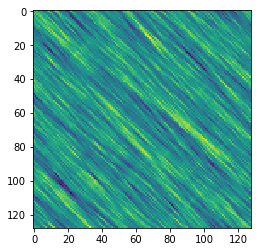

In [21]:
plt.figure()
plt.imshow(img[...,0])
plt.show()

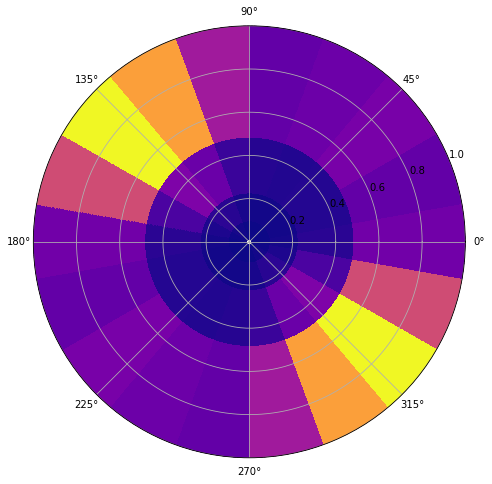

In [20]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np

cmap = plt.get_cmap('plasma')
levels = MaxNLocator(nbins=1000).tick_values(z.min(), z.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0,0,1,1], polar=True)
im = ax1.pcolormesh(np.deg2rad(theta), r, z, cmap=cmap, norm=norm)
ax1.grid(True)
plt.show()

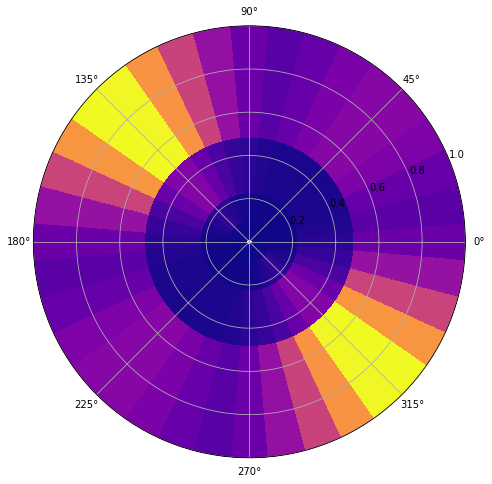

In [123]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np

cmap = plt.get_cmap('plasma')
levels = MaxNLocator(nbins=1000).tick_values(z.min(), z.max())
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes([0,0,1,1], polar=True)
im = ax1.pcolormesh(np.deg2rad(theta), r, z, cmap=cmap, norm=norm)
ax1.grid(True)
plt.show()